# Calc domain fractions in kmaps

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, measure, exposure, feature, color

Read the data and store it in the `small_1` dictionary. Access the intensity by calling `small_1[<scan_no>]['<roi>'][2]`.

In [4]:
sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]

# for i,scan in enumerate(scan_list):
#     scan_list[i] = scan + 3
    
print(scan_list)    

small_1 = dict()
for scan in scan_list:
    small_1[scan] = c.read_kmap(sf, scan, rois_103) # out is piy, pix, int per each roi

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]


Define a function to calc and correct the shift between two images. Use the `register_translation` function to do so, and shift the image with `ndimage.shift` function. Fill in the shifted image remaining areas with 0s, do not use spline interpolation (see [here](http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.ndimage.shift.html))

In [5]:
# def correct_shift_nd(im1, im2, indexes=None):
#     if indexes != None: # calc shift only for portion of img -NOT SURE IT'S OK
#         idx = np.s_[indexes[0]:indexes[1],indexes[2]:indexes[3]]
#     else:
#         idx = np.s_[:,:]
#     # calc shift
#     shift, error, diffphase = feature.register_translation(im1[idx],im2[idx]) # add ,100 for subpixel
#     # shift image
#     win2 = nd.shift(im2,shift,order=0)
    
#     return win2

Prepare data:

In [6]:
roi = 'roi2'
small_roi = []
for scan in scan_list:
    small_roi.append(small_1[scan][roi][2].T[::-1]) # list of roi2 intensity ndarrays

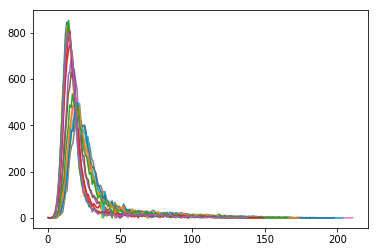

In [7]:
%matplotlib inline
for scan in small_roi:
    hist, bins_centre = exposure.histogram(scan,nbins=int(scan.max()))
#     small_roi = small_roi / small_roi[0].max()
    plt.plot(bins_centre,hist)

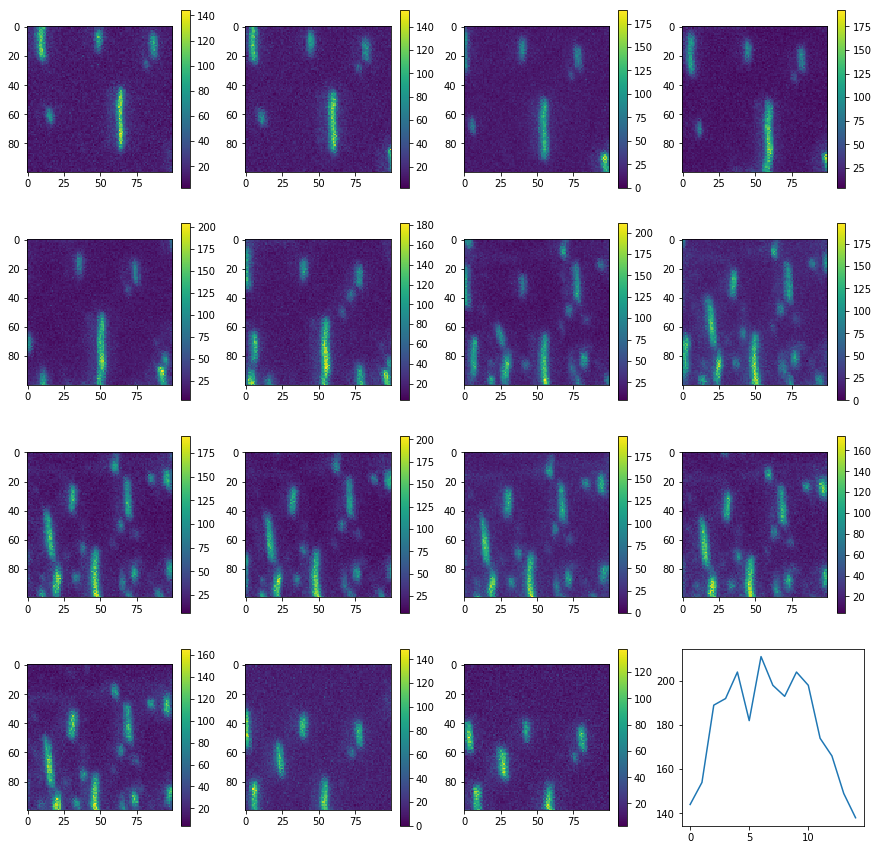

In [8]:
fig, ax = plt.subplots(4,4,figsize=(15,15))
axes = ax.ravel()

for index, ax in enumerate(axes):
    try:
        im = ax.imshow(small_roi[index])
        plt.colorbar(im,ax=ax)
    except IndexError:
        pass
    
axes[15].plot([x.max() for x in small_roi])

Correct shift with roi5 data:

In [9]:
roi = 'roi5'
small_roi5 = []
for scan in scan_list:
    small_roi5.append(small_1[scan][roi][2].T[::-1]) # list of roi2 intensity ndarrays

Correct the shift with `correct_shift_nd`, all shifts computed for all images with respect to the first image.

In [13]:
windows = []
for index in range(1, len(small_roi)):
    if index == 1:
        windows.append(small_roi[0])
        # calc shift using roi5 data
        shift, error, diffphase = feature.register_translation(small_roi5[0],small_roi5[index])
        # shift the choisen roi img with this shift
        shifted_img = nd.shift(small_roi[index],shift,order=0)
        # save the shifted img
        windows.append(shifted_img)
    else:
        shift, error, diffphase = feature.register_translation(small_roi5[0],small_roi5[index])
        shifted_img = nd.shift(small_roi[index],shift,order=0)
        windows.append(shifted_img)

# windows = [] # list of shift corrected images
# for index in range(1,len(small_roi)):
#     if index == 1: 
#         windows.append(small_roi[0]) # first img
#         win2 = correct_shift_nd(small_roi[0],small_roi[index])
#         windows.append(win2)
#     else:
#         win2 = correct_shift_nd(small_roi[0],small_roi[index])
#         windows.append(win2)                   

Restrict the visible window to the largest displacement in x and y, and inspect the images:

In [14]:
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150]

In [16]:
%matplotlib inline
from ipywidgets import interact

# calc largest shifts in x y
shifts = []
for index in range(1,len(small_roi)):
    shift, error, diffphase = feature.register_translation(small_roi5[0],small_roi5[index])
    print(shift)
    shifts.append(shift)

shifts = np.array(shifts)
y_max = int(abs(shifts[:,0]).max())
x_max = int(abs(shifts[:,1]).max())

print('max shift in y: {0} \nmax shift in x: {1}'.format(y_max,x_max))

# select smallest window
if shifts[:,0].max() > 0:
    winidx = np.s_[y_max:,x_max:]
elif shifts[:,0].max() < 0:
    winidx = np.s_[:len(small_roi[0])-y_max,x_max:]
    
piy_win = small_1[scan_list[0]][roi][0][winidx]
pix_win = small_1[scan_list[0]][roi][1][winidx]

@interact(i=(0, len(windows)-1))
def plot(i=0):
    plt.imshow(windows[i][winidx], extent=(piy_win[0].min(),piy_win[0].max(),pix_win[:,0].min(),pix_win[:,0].max()))
#     plt.imshow(windows[i])
    plt.title('{0} V'.format(voltages[i]))
    plt.ylabel('pix')
    plt.xlabel('piy')
#     plt.savefig('small_2gif_{0}'.format(i+100))
#     plt.pcolormesh(piy_win,pix_win,windows[i][winidx])
#     plt.axis('scaled')

[-1.  4.]
[-6.  9.]
[-7.  4.]
[ -7.  13.]
[-10.   9.]
[-22.   9.]
[-22.  13.]
[-24.  17.]
[-25.  15.]
[-27.  19.]
[-30.  17.]
[-34.  17.]
[-33.   9.]
[-35.   6.]
max shift in y: 35 
max shift in x: 19


interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',))

Calc the areas:

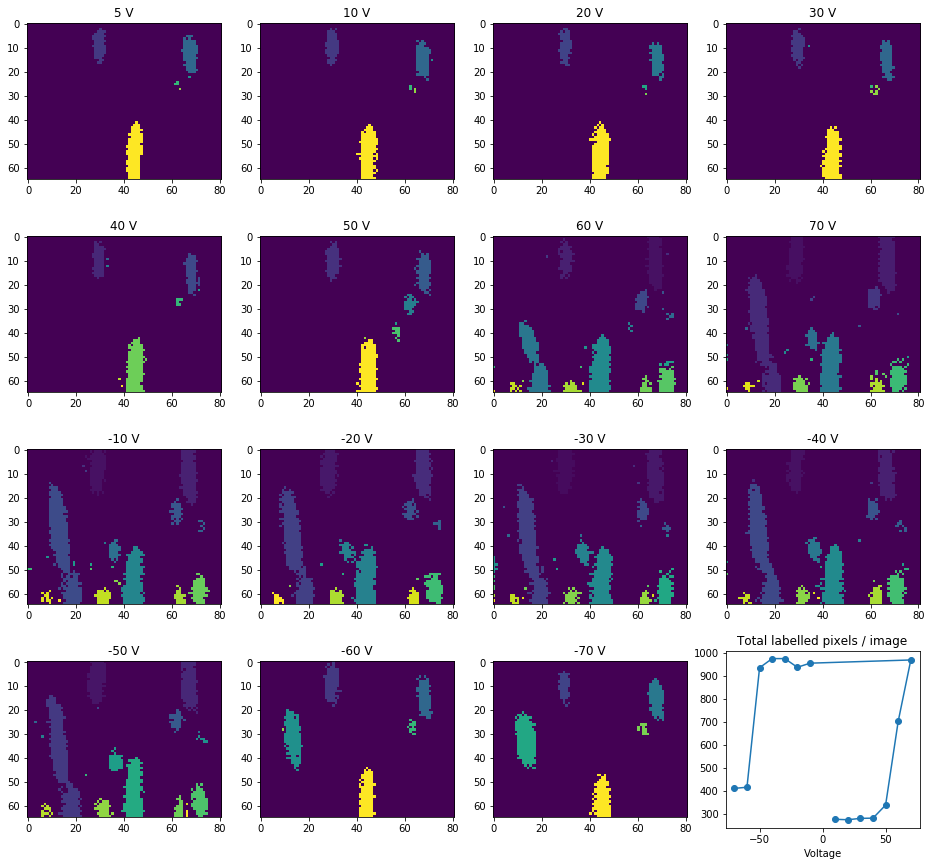

In [18]:
fig, ax = plt.subplots(4,4,figsize=(16,15))
axes = ax.ravel()

tot_areas = []
# for index,img in enumerate(small_roi):
first_threshold = filters.threshold_otsu(windows[0])
for index,img in enumerate(windows):
    img = img[winidx] # restrict all computations to smallest window
#     thresholded_img = img < filters.threshold_otsu(img)
    thresholded_img = img < first_threshold
    labelled_img = measure.label(thresholded_img,background=1)
    regions = measure.regionprops(labelled_img)
    
    axes[index].imshow(labelled_img)
    axes[index].set_title('{0} V'.format(voltages[index]))
    
    # calc areas
    areas = []
    for region in regions:
        areas.append(region.area)
        
    # calc total area / windowed image
    totarea = np.array(areas).sum()
    tot_areas.append(totarea)
    
axes[len(axes)-1].plot(voltages[1:len(voltages)-2],tot_areas[1:],marker='o')
axes[len(axes)-1].set_title('Total labelled pixels / image')
axes[len(axes)-1].set_xlabel('Voltage')
# axes[len(axes)-1].set_yscale('log')

plt.show()

## Inspect weird images

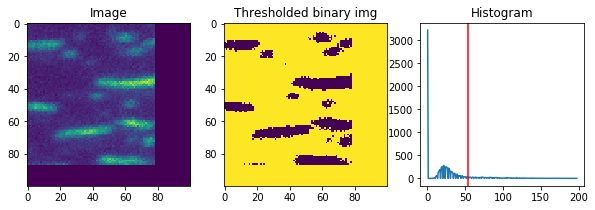

In [35]:
data = windows[7].T[::-1]

# establish threshold for binarisation
threshold = filters.threshold_otsu(data)
# calc image historgram to see where threshold lies
hist, bins_centre = exposure.histogram(data)
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.set_title('Image')
ax1.imshow(data)
ax2.set_title('Thresholded binary img')
ax2.imshow(data<threshold)
ax3.set_title('Histogram')
ax3.plot(bins_centre,hist)
ax3.axvline(threshold, c='r');